In [21]:
from school_analysis.preprocessing.load import Loader
import pandas as pd

loader = Loader()

def load_special_edu_support_percentage():
    melted_df = loader.load('students_with_special_educational_support_no_gender')

    melted_df['year'] = pd.to_datetime(melted_df['year'], format='%Y')
    melted_df['total'] = pd.to_numeric(melted_df['total'], errors='coerce')

    melted_df = melted_df[(melted_df['school'] == "Grammar schools (8 years of schooling)") | (melted_df['school'] == "Grammar schools (9 years of schooling)")]
    total_over_years = melted_df.groupby(['year'])['total'].sum()

    children_type = loader.load('school-children-by-type')
    children_type = children_type.rename(columns={'Year': 'year'})
    children_type = children_type.rename(columns={'School Type': 'school'})
    children_type = children_type.rename(columns={'total': 'Value'})
    children_type['year'] = pd.to_datetime(children_type['year'], format='%Y')
    children_type['Value'] = pd.to_numeric(children_type['Value'], errors='coerce')
    child_amount_per_year = children_type.groupby(['year'])['Value'].sum()
    
    merged_df = pd.merge(total_over_years, child_amount_per_year,on=['year'])
    merged_df['edu_support_relative'] = merged_df['total']/merged_df['Value'] 
    return merged_df

def load_grades():
    grades = loader.load("abi-grades")
    grades_temp = grades.T.reset_index().rename(
    columns={"level_0": "Federal State", "level_1": "Year"})
    grades = pd.melt(grades_temp, id_vars=["Federal State", "Year"], value_vars=grades_temp.columns[2:], value_name="Value")    
    grades["Grade"] = grades["Grade"].astype(float)
    
    avg_grade_year = grades.groupby(["Year"]).apply(lambda x: (x["Grade"] * x["Value"]).sum() / x["Value"].sum()).reset_index().rename(columns={0: "Average Grade"})  
    avg_grade_year = avg_grade_year.rename(columns={'Year': 'year'})
    avg_grade_year['year'] = pd.to_datetime(avg_grade_year['year'], format='%Y')
    return avg_grade_year

grades = load_grades()
special_edu_support = load_special_edu_support_percentage()

grades


KeyError: 'Value'

In [ ]:
#we just can correlate over the years, because special educational support by states such as school type for the grades is not available
merged_df = pd.merge(grades, special_edu_support, on=['year'])
merged_df

,year,Average Grade,total,Value,edu_support_relative
0,2007-01-01,2.530665,1321.0,9183811.0,0.000144
1,2008-01-01,2.523515,1588.0,9023572.0,0.000176
2,2009-01-01,2.517675,1911.0,8905800.0,0.000215
3,2010-01-01,2.500708,2320.0,8796894.0,0.000264
4,2011-01-01,2.498626,2696.0,8678196.0,0.000311
5,2012-01-01,2.472224,3289.0,8556879.0,0.000384
6,2013-01-01,2.459223,3834.0,8420111.0,0.000455
7,2014-01-01,2.456677,4577.0,8366666.0,0.000547
8,2015-01-01,2.454814,5546.0,8335061.0,0.000665
9,2016-01-01,2.435339,6524.0,8369513.0,0.000779


In [ ]:
correlation_coefficient = merged_df['edu_support_relative'].corr(merged_df['Average Grade'])
correlation_coefficient

-0.8749258308522208

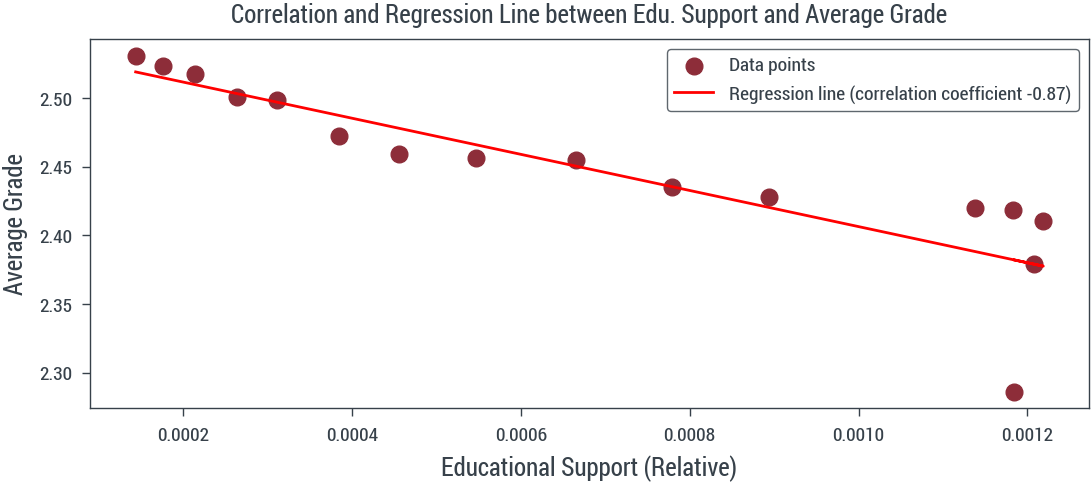

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_correlation_with_regression(dataframe):
    x = dataframe['edu_support_relative']
    y = dataframe['Average Grade']

    # Calculating the regression line
    m, b = np.polyfit(x, y, 1)

    # Creating the scatter plot
    scatter = plt.scatter(x, y, label='Data points')
    plt.plot(x, m*x + b, color='red', label=f'Regression line (correlation coefficient {round(correlation_coefficient,2)})')  # Regression line

    # Adding labels and title
    plt.title('Correlation and Regression Line between Edu. Support and Average Grade')
    plt.xlabel('Educational Support (Relative)')
    plt.ylabel('Average Grade')

    # Adding the legend
    plt.legend()

    plt.show()

plot_correlation_with_regression(merged_df)